### HARTH Dataset Overview

The Human Activity Recognition Trondheim (HARTH) dataset is a comprehensive collection of recordings from 22 participants, each wearing:

#### Sensors
- 2 x 3-axial Axivity AX3 accelerometers
  - Positioned on the right thigh and lower back
  - Capturing motion data for approximately 2 hours in a free-living environment

### Key Features

#### Data Quality
- **Rich, professionally annotated data**
- *Ideal for developing advanced machine learning models*
- ***Focus on precise Human Activity Recognition (HAR) in real-world settings***

This dataset provides a valuable benchmark for researchers and developers working on HAR applications.

### Markdown codes used:
- ** for bold text
- * for italic text
- *** for bold italic text
- #### for headings (H4 level)
- ### for headings (H3 level)


In [2]:
import os
import io
import zipfile
import requests

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, 
    precision_score, recall_score, f1_score
)

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, 
    Concatenate, Dropout, BatchNormalization, Activation
)

from keras.utils import to_categorical  # Note: This seems to be a duplicate import

Initial Data Exploration


Loaded S029.csv with shape: (178716, 9)
Loaded S028.csv with shape: (165178, 9)
Loaded S027.csv with shape: (158584, 9)
Loaded S026.csv with shape: (195172, 9)
Loaded S025.csv with shape: (231729, 9)
Loaded S024.csv with shape: (170534, 9)
Loaded S023.csv with shape: (137646, 10)
Loaded S022.csv with shape: (337602, 9)
Loaded S021.csv with shape: (302247, 10)
Loaded S020.csv with shape: (371496, 9)
Loaded S019.csv with shape: (297945, 9)
Loaded S018.csv with shape: (322271, 9)
Loaded S017.csv with shape: (366609, 9)
Loaded S016.csv with shape: (355418, 9)
Loaded S015.csv with shape: (418392, 10)
Loaded S014.csv with shape: (366487, 9)
Loaded S013.csv with shape: (369077, 9)
Loaded S012.csv with shape: (382414, 9)
Loaded S010.csv with shape: (351649, 9)
Loaded S009.csv with shape: (154464, 9)
Loaded S008.csv with shape: (418989, 9)
Loaded S006.csv with shape: (408709, 9)
Combined DataFrame shape: (6461328, 11)
Data Types:
timestamp       object
back_x         float64
back_y         floa

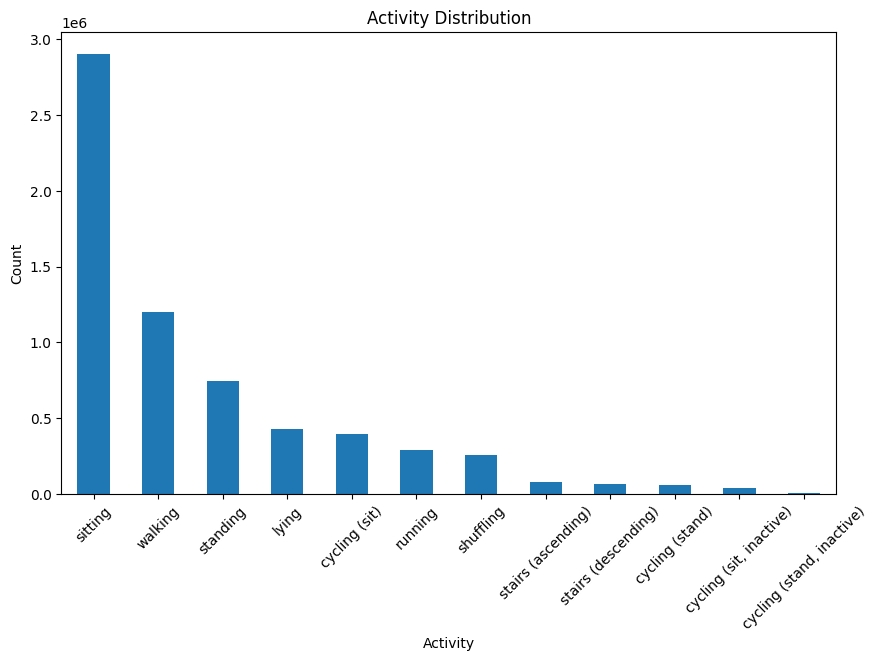

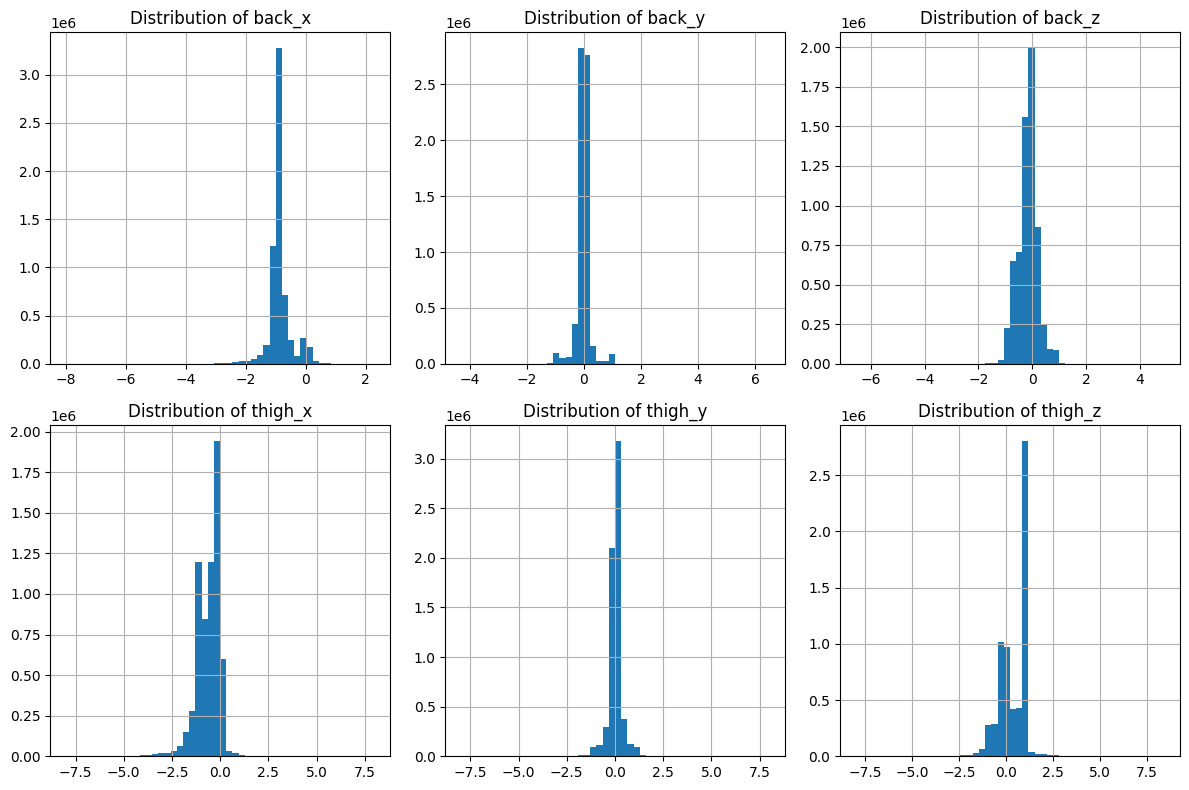

Correlation Matrix:
              back_x    back_y    back_z   thigh_x   thigh_y   thigh_z  \
back_x      1.000000  0.014058 -0.103727  0.435847  0.052864 -0.043389   
back_y      0.014058  1.000000  0.027343  0.002271 -0.187453  0.017320   
back_z     -0.103727  0.027343  1.000000 -0.105903  0.027760 -0.165214   
thigh_x     0.435847  0.002271 -0.105903  1.000000  0.159553  0.429772   
thigh_y     0.052864 -0.187453  0.027760  0.159553  1.000000  0.149124   
thigh_z    -0.043389  0.017320 -0.165214  0.429772  0.149124  1.000000   
Unnamed: 0 -0.327393 -0.123978 -0.591631 -0.369210 -0.143922  0.394655   
index       0.194146 -0.014989 -0.166039 -0.028248 -0.049817 -0.073353   

            Unnamed: 0     index  
back_x       -0.327393  0.194146  
back_y       -0.123978 -0.014989  
back_z       -0.591631 -0.166039  
thigh_x      -0.369210 -0.028248  
thigh_y      -0.143922 -0.049817  
thigh_z       0.394655 -0.073353  
Unnamed: 0    1.000000       NaN  
index              NaN  1.000000 

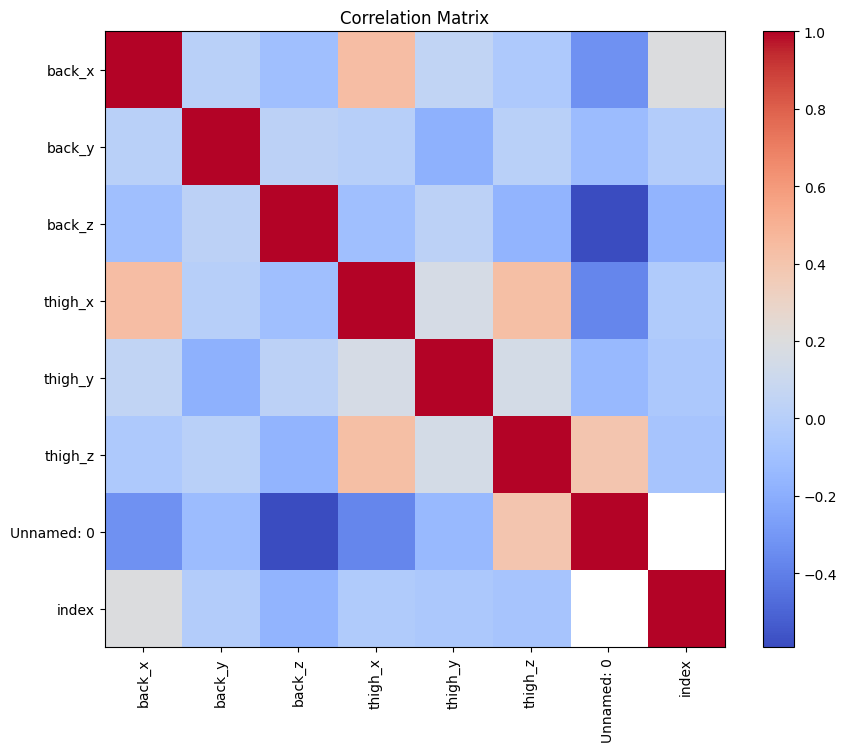

In [9]:
import requests
import zipfile
import io
import pandas as pd
import matplotlib.pyplot as plt

# URL for UCI data
zip_file_url = "https://archive.ics.uci.edu/static/public/779/harth.zip"
files = [
    'S029.csv', 'S028.csv', 'S027.csv', 'S026.csv', 'S025.csv',
    'S024.csv', 'S023.csv', 'S022.csv', 'S021.csv', 'S020.csv',
    'S019.csv', 'S018.csv', 'S017.csv', 'S016.csv', 'S015.csv',
    'S014.csv', 'S013.csv', 'S012.csv', 'S010.csv', 'S009.csv',
    'S008.csv', 'S006.csv',
]
data_types = {
    'back_x': 'float64', 'back_y': 'float64', 'back_z': 'float64',
    'thigh_x': 'float64', 'thigh_y': 'float64', 'thigh_z': 'float64',
    'label': 'int32'
}

activity_labels = {
    1: 'walking',
    2: 'running',
    3: 'shuffling',
    4: 'stairs (ascending)',
    5: 'stairs (descending)',
    6: 'standing',
    7: 'sitting',
    8: 'lying',
    13: 'cycling (sit)',
    14: 'cycling (stand)',
    130: 'cycling (sit, inactive)',
    140: 'cycling (stand, inactive)'
}

# Function to load individual CSV files into pandas DataFrame with metadata
def load_csv(file_name, zip_file):
    with zip_file.open('harth/' + file_name) as csv_file:
        df = pd.read_csv(csv_file, dtype=data_types)
        df['source_file'] = file_name  # Adding metadata as a new column
        if df.empty:
            print(f"Warning: {file_name} is empty.")
        else:
            print(f"Loaded {file_name} with shape: {df.shape}")
        return df

response = requests.get(zip_file_url)
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
    dataframes = [load_csv(file_name, zip_file) for file_name in files]

combined_df = pd.concat(dataframes, ignore_index=True)

# Map activity labels
combined_df['label'] = combined_df['label'].map(activity_labels)

print(f"Combined DataFrame shape: {combined_df.shape}")
if combined_df.empty:
    raise ValueError("The combined DataFrame is empty. Check if the files are being loaded correctly.")

# Initial Data Exploration

# Check data types
print("Data Types:")
print(combined_df.dtypes)

# Inspect the first few rows
print("First few rows:")
print(combined_df.head())

# Check for missing values
print("Missing Values:")
print(combined_df.isnull().sum())

# Get descriptive statistics
print("Descriptive Statistics:")
print(combined_df.describe())

# Visualize the distribution of activities
activity_counts = combined_df['label'].value_counts()
plt.figure(figsize=(10, 6))
activity_counts.plot(kind='bar')
plt.title('Activity Distribution')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Visualize the distribution of sensor data
plt.figure(figsize=(12, 8))
for i, column in enumerate(['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z'], 1):
    plt.subplot(2, 3, i)
    combined_df[column].hist(bins=50)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

# Correlation matrix for numeric columns only
numeric_df = combined_df.select_dtypes(include=['float64', 'int32'])
corr_matrix = numeric_df.corr()
print("Correlation Matrix:")
print(corr_matrix)

plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.title('Correlation Matrix')
plt.show()


In [10]:
# Data Processing

# Handle missing values (if any)
combined_df.fillna(method='ffill', inplace=True)

# Normalize/Standardize sensor data
scaler = StandardScaler()
sensor_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
combined_df[sensor_columns] = scaler.fit_transform(combined_df[sensor_columns])

# Encode categorical variables (activity labels) if necessary
label_encoder = LabelEncoder()
combined_df['label_encoded'] = label_encoder.fit_transform(combined_df['label'])

# Verify the processed data
print("Processed Data Types:")
print(combined_df.dtypes)

print("First few rows of the processed data:")
print(combined_df.head())

# Save the processed data for future use
combined_df.to_csv('processed_harth_data.csv', index=False)


C:\Users\Board\AppData\Local\Temp\ipykernel_33408\3926389168.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df.fillna(method='ffill', inplace=True)


Processed Data Types:
timestamp         object
back_x           float64
back_y           float64
back_z           float64
thigh_x          float64
thigh_y          float64
thigh_z          float64
label             object
source_file       object
Unnamed: 0       float64
index            float64
label_encoded      int32
dtype: object
First few rows of the processed data:
                 timestamp    back_x    back_y    back_z   thigh_x   thigh_y  \
0  2019-01-12 00:00:00.000 -0.304675 -0.251017 -0.125992 -0.642107 -0.373650   
1  2019-01-12 00:00:00.020 -0.304675 -0.308048 -0.112604 -0.590657 -0.330283   
2  2019-01-12 00:00:00.040 -0.298210 -0.424217 -0.081815 -0.600790 -0.334054   
3  2019-01-12 00:00:00.060 -0.322133 -0.544613 -0.110597 -0.624568 -0.342225   
4  2019-01-12 00:00:00.080 -0.384202 -0.548840 -0.162807 -0.624178 -0.381818   

    thigh_z     label source_file  Unnamed: 0  index  label_encoded  
0 -0.315966  standing    S029.csv         NaN    NaN             10  
1 -0.

Descriptive Statistics Across Activities:
                        label    back_x                                 \
                                   mean       std        min       max   
0               cycling (sit) -0.040765  0.448036 -10.484971  3.894172   
1     cycling (sit, inactive)  0.075854  0.387719  -4.378572  2.518138   
2             cycling (stand)  0.165118  0.849566  -6.694113  3.655586   
3   cycling (stand, inactive) -0.042744  0.295575  -6.166462  2.038476   
4                       lying  2.270088  0.345130  -2.393313  3.703409   
5                     running -0.212724  2.949901 -18.843224  6.840794   
6                   shuffling -0.257947  0.282447  -8.925193  7.241568   
7                     sitting -0.092105  0.350581  -6.778590  2.969572   
8          stairs (ascending) -0.201641  0.709805  -6.770002  4.766066   
9         stairs (descending) -0.291021  1.001571 -11.529522  4.617192   
10                   standing -0.266912  0.183635 -17.255887  6.807112

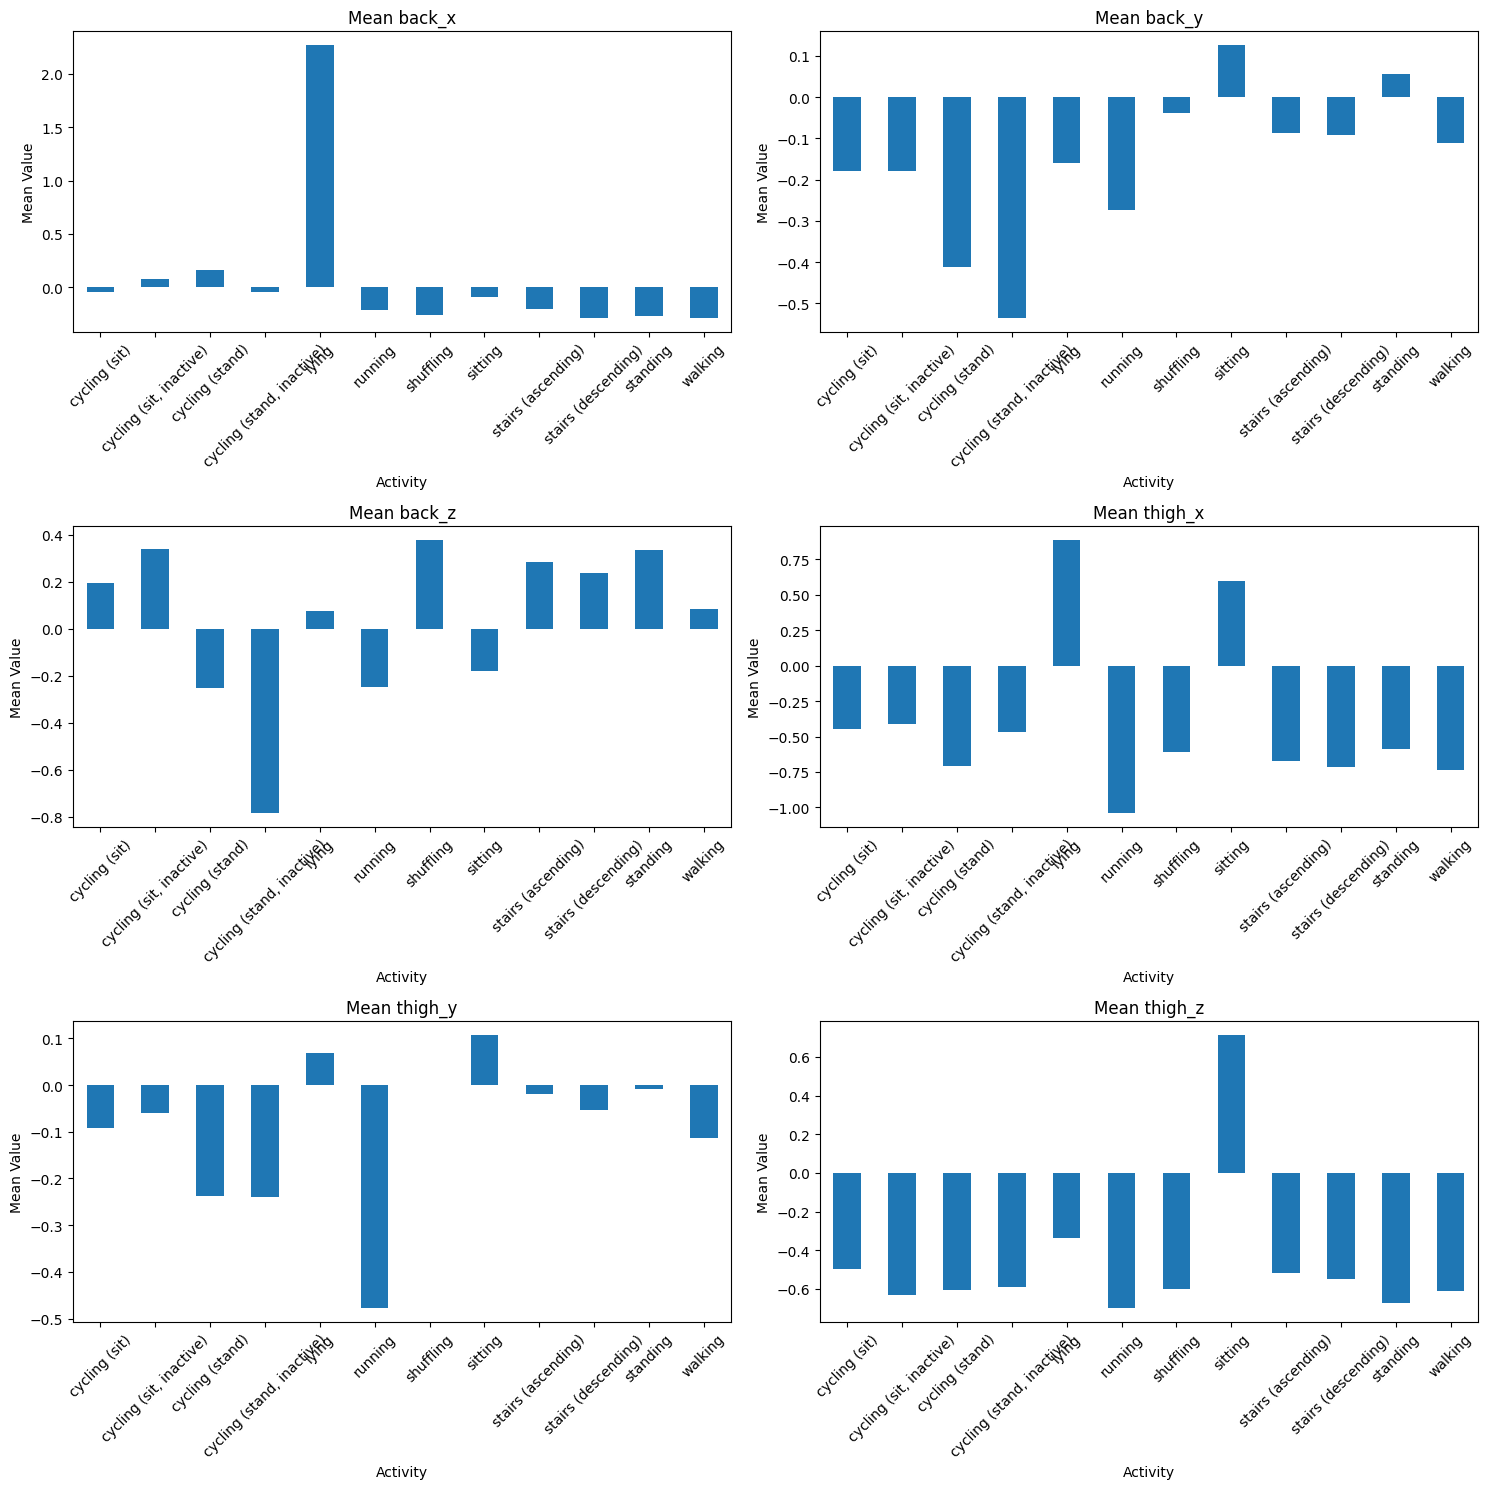

In [12]:
# Calculate descriptive statistics for each sensor reading grouped by activity
activity_stats = combined_df.groupby('label')[sensor_columns].agg(['mean', 'std', 'min', 'max']).reset_index()

# Display the descriptive statistics
print("Descriptive Statistics Across Activities:")
print(activity_stats)

# Plot descriptive statistics for each sensor reading across activities
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

for i, column in enumerate(sensor_columns):
    ax = axes[i//2, i%2]
    combined_df.groupby('label')[column].mean().plot(kind='bar', ax=ax, title=f'Mean {column}')
    ax.set_xlabel('Activity')
    ax.set_ylabel('Mean Value')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


At thsi point as per our discussion  we will want to hypotheise sensor data and corelate to calorie burn 

Data with Hypothetical Calorie Burn:
                 timestamp    back_x    back_y    back_z   thigh_x   thigh_y  \
0  2019-01-12 00:00:00.000 -0.304675 -0.251017 -0.125992 -0.642107 -0.373650   
1  2019-01-12 00:00:00.020 -0.304675 -0.308048 -0.112604 -0.590657 -0.330283   
2  2019-01-12 00:00:00.040 -0.298210 -0.424217 -0.081815 -0.600790 -0.334054   
3  2019-01-12 00:00:00.060 -0.322133 -0.544613 -0.110597 -0.624568 -0.342225   
4  2019-01-12 00:00:00.080 -0.384202 -0.548840 -0.162807 -0.624178 -0.381818   

    thigh_z     label source_file  Unnamed: 0  index  label_encoded  \
0 -0.315966  standing    S029.csv         NaN    NaN             10   
1 -0.291090  standing    S029.csv         NaN    NaN             10   
2 -0.277161  standing    S029.csv         NaN    NaN             10   
3 -0.299714  standing    S029.csv         NaN    NaN             10   
4 -0.298720  standing    S029.csv         NaN    NaN             10   

   calorie_burn  
0           1.5  
1           1.5  
2

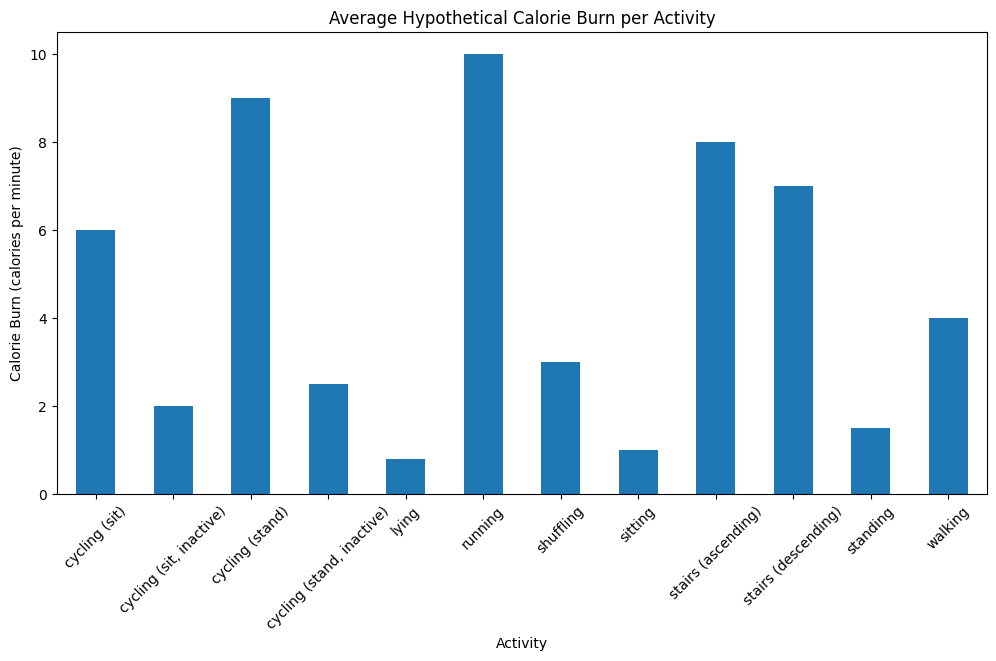

In [13]:
# Hypothetical calorie burn values (calories per minute) based on activity intensity
calorie_burn_rates = {
    'walking': 4,
    'running': 10,
    'shuffling': 3,
    'stairs (ascending)': 8,
    'stairs (descending)': 7,
    'standing': 1.5,
    'sitting': 1,
    'lying': 0.8,
    'cycling (sit)': 6,
    'cycling (stand)': 9,
    'cycling (sit, inactive)': 2,
    'cycling (stand, inactive)': 2.5
}

# Add hypothetical calorie burn column
combined_df['calorie_burn'] = combined_df['label'].map(calorie_burn_rates)

# Display first few rows to verify
print("Data with Hypothetical Calorie Burn:")
print(combined_df.head())

# Visualize the average calorie burn per activity
plt.figure(figsize=(12, 6))
combined_df.groupby('label')['calorie_burn'].mean().plot(kind='bar')
plt.title('Average Hypothetical Calorie Burn per Activity')
plt.xlabel('Activity')
plt.ylabel('Calorie Burn (calories per minute)')
plt.xticks(rotation=45)
plt.show()


Correlation of Sensor Readings with Hypothetical Calorie Burn:
back_x    -0.141856
back_y    -0.110045
back_z     0.031578
thigh_x   -0.498149
thigh_y   -0.126606
thigh_z   -0.402175
Name: calorie_burn, dtype: float64


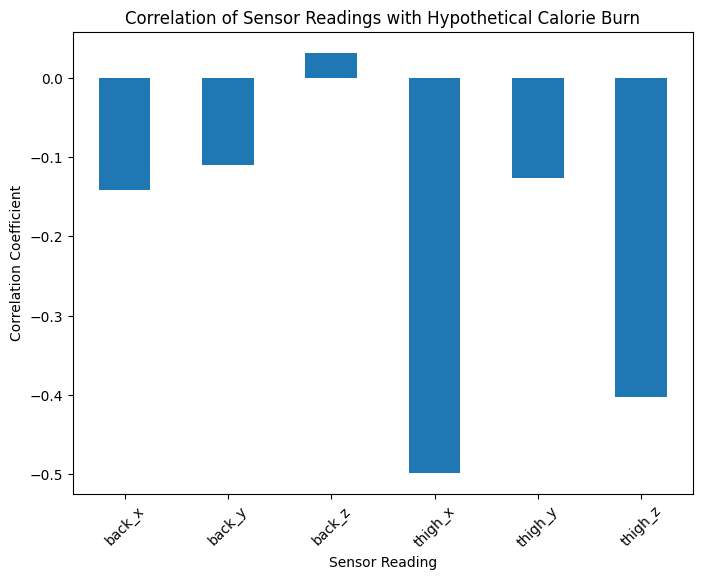

In [14]:
# Correlation between sensor readings and hypothetical calorie burn
corr_with_calories = combined_df[sensor_columns + ['calorie_burn']].corr()['calorie_burn'].drop('calorie_burn')

print("Correlation of Sensor Readings with Hypothetical Calorie Burn:")
print(corr_with_calories)

# Visualize the correlation
plt.figure(figsize=(8, 6))
corr_with_calories.plot(kind='bar')
plt.title('Correlation of Sensor Readings with Hypothetical Calorie Burn')
plt.xlabel('Sensor Reading')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()


Explanation:
Calculate Correlation Matrix: This includes both the sensor data columns and the hypothetical calorie burn column.
Plot Correlation Matrix: Uses seaborn's heatmap to visualize the correlation matrix, with annotations for the correlation coefficients.

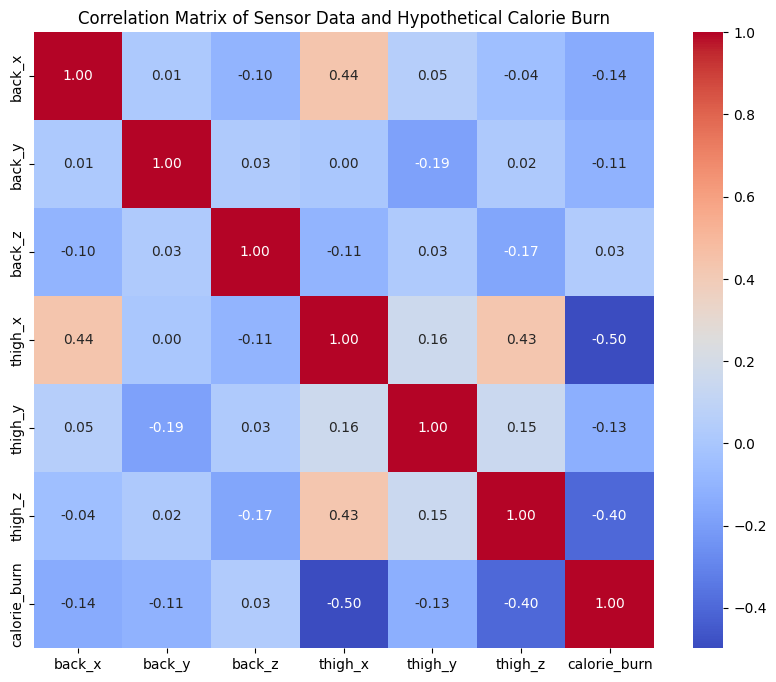

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix including the hypothesized calorie burn
correlation_matrix = combined_df[sensor_columns + ['calorie_burn']].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Sensor Data and Hypothetical Calorie Burn')
plt.show()


CNN Model 

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Ensure reproducibility
np.random.seed(42)

# Extract features and labels
X = combined_df[sensor_columns].values
y = combined_df['calorie_burn'].values

# Reshape X to fit CNN input shape (samples, height, width, channels)
X = X.reshape((X.shape[0], 1, X.shape[1], 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the labels (calorie burn) to a range suitable for regression
y_train = y_train / np.max(y_train)
y_test = y_test / np.max(y_test)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (5169062, 1, 6, 1)
Shape of y_train: (5169062,)
Shape of X_test: (1292266, 1, 6, 1)
Shape of y_test: (1292266,)


In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Ensure reproducibility
np.random.seed(42)

# Extract features and labels
X = combined_df[sensor_columns].values
y = combined_df['calorie_burn'].values

# Normalize the labels (calorie burn) to a range suitable for regression
y = y / np.max(y)

# Reshape X to fit CNN input shape (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (5169062, 6, 1)
Shape of y_train: (5169062,)
Shape of X_test: (1292266, 6, 1)
Shape of y_test: (1292266,)


C:\Users\Board\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 5, 32)          │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 4, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,281 (145.63 KB)

 Trainable params: 37,281 (145.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
129227/129227 ━━━━━━━━━━━━━━━━━━━━ 628s 5ms/step - loss: 0.0186 - mae: 0.0853 - val_loss: 0.0128 - val_mae: 0.0609
Epoch 2/30
129227/129227 ━━━━━━━━━━━━━━━━━━━━ 584s 5ms/step - loss: 0.0153 - mae: 0.0767 - val_loss: 0.0120 - val_mae: 0.0613
Epoch 3/30
129227/129227 ━━━━━━━━━━━━━━━━━━━━ 587s 5ms/step - loss: 0.0151 - mae: 0.0760 - val_loss: 0.0115 - val_mae: 0.0566
Epoch 4/30
129227/129227 ━━━━━━━━━━━━━━━━━━━━ 589s 5ms/step - loss: 0.0150 - mae: 0.0757 - val_loss: 0.0118 - val_mae: 0.0557
Epoch 5/30
129227/129227 ━━━━━━━━━━━━━━━━━━━━ 577s 4ms/step - loss: 0.0150 - mae: 0.0756 - val_loss: 0.0113 - val_mae: 0.0547
Epoch 6/30
129227/129227 ━━━━━━━━━━━━━━━━━━━━ 573s 4ms/step - loss: 0.0149 - mae: 0.0755 - val_loss: 0.0123 - val_mae: 0.0553
Epoch 7/30
129227/129227 ━━━━━━━━━━━━━━━━━━━━ 586s 5ms/step - loss: 0.0149 - mae: 0.0752 - val_loss: 0.0113 - val_mae: 0.0551
Epoch 8/30
129227/129227 ━━━━━━━━━━━━━━━━━━━━ 578s 4ms/step - loss: 0.0148 - mae: 0.0752 - val_loss: 0.0119 - val_mae:

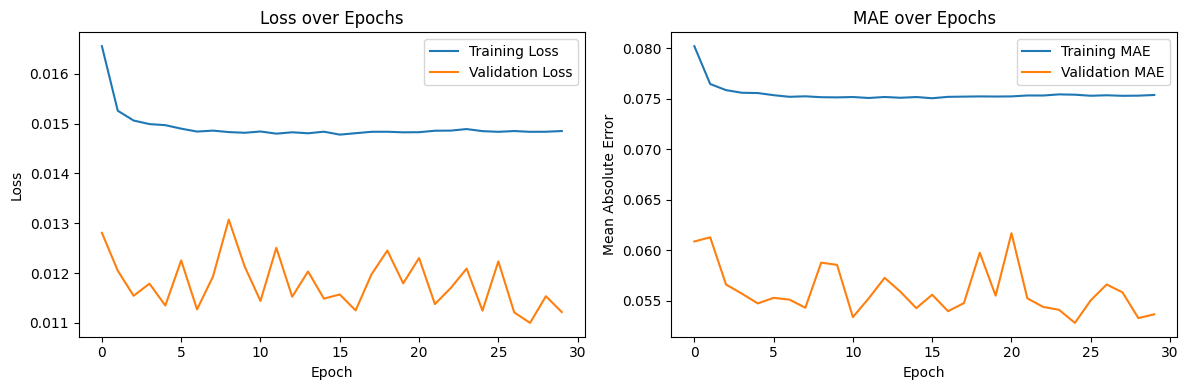

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, MaxPooling1D

# Ensure reproducibility
np.random.seed(42)

# Extract features and labels
sensor_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
X = combined_df[sensor_columns].values
y = combined_df['calorie_burn'].values

# Normalize the labels (calorie burn) to a range suitable for regression
y = y / np.max(y)

# Reshape X to fit CNN input shape (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model using 1D convolutions
model = Sequential([
    Conv1D(32, 2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=1),
    Dropout(0.25),
    
    Conv1D(64, 2, activation='relu'),
    MaxPooling1D(pool_size=1),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='linear')  # For regression, use linear activation
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=2)
print("Test Mean Absolute Error:", test_mae)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()


Model Evaluation


40384/40384 - 82s - 2ms/step - loss: 0.0112 - mae: 0.0536
Test Mean Absolute Error: 0.05360521376132965


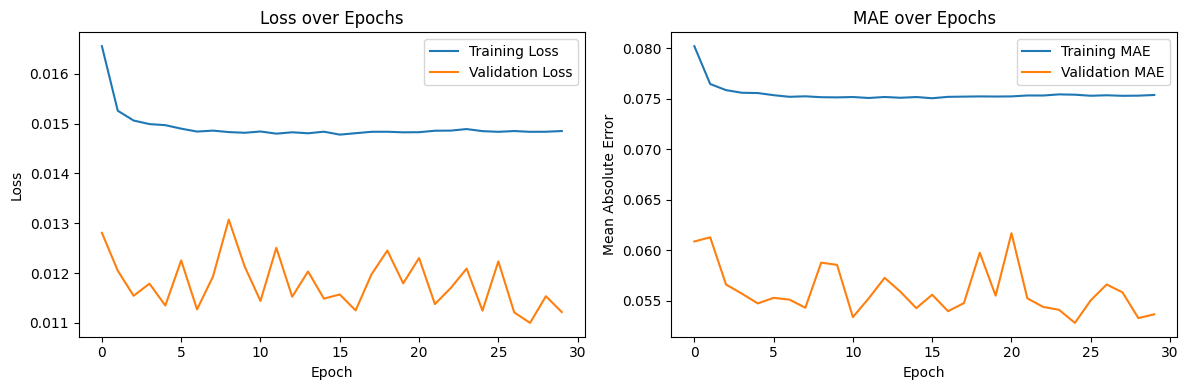

40384/40384 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step


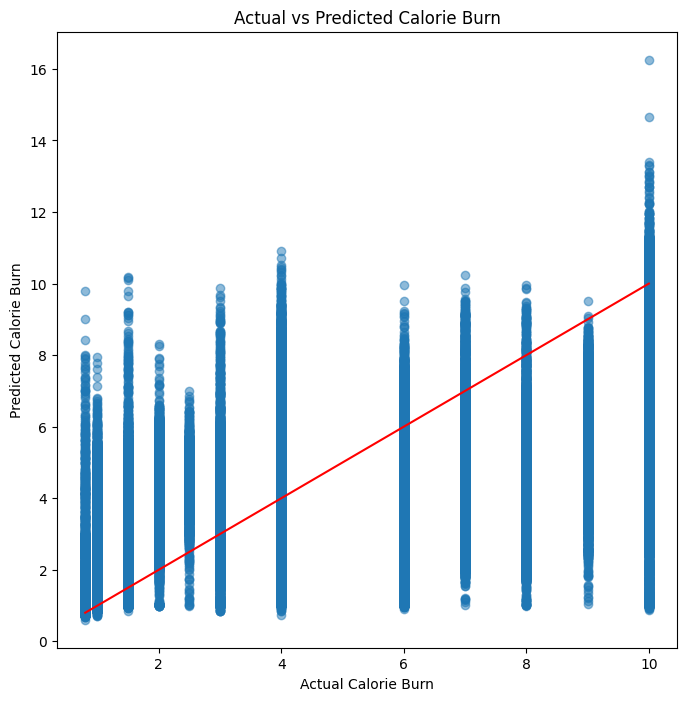

Mean Absolute Error (MAE): 0.5360510207545667
Mean Squared Error (MSE): 1.1227110304835126
R-squared (R2): 0.8112102268982598


In [28]:
# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=2)
print("Test Mean Absolute Error:", test_mae)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

# Predict on the test set
y_pred = model.predict(X_test)

# Rescale predictions and actual values to original scale
y_pred_rescaled = y_pred * np.max(combined_df['calorie_burn'])
y_test_rescaled = y_test * np.max(combined_df['calorie_burn'])

# Scatter plot of predicted vs actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.5)
plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], color='red')
plt.xlabel('Actual Calorie Burn')
plt.ylabel('Predicted Calorie Burn')
plt.title('Actual vs Predicted Calorie Burn')
plt.show()

# Calculate and print evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")
